In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
import time
torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)

import pandas as pd

In [2]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons, retrain_seed=42):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer
        self.neurons = neurons
        # Number of hidden layers
        self.n_hidden_layers = n_hidden_layers
        # Activation function
        self.activation = nn.Tanh()

        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers - 1)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)
        self.retrain_seed = retrain_seed
        # Random Seed for weight initialization
        self.init_xavier()

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)

    def init_xavier(self):
        torch.manual_seed(self.retrain_seed)

        def init_weights(m):
            if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                g = nn.init.calculate_gain('tanh')
                torch.nn.init.xavier_uniform_(m.weight, gain=g)
                # torch.nn.init.xavier_normal_(m.weight, gain=g)
                m.bias.data.fill_(0)

        self.apply(init_weights)


In [3]:
class Pinns:
    def __init__(self, n_int_, n_sb_, n_tb_,
                 alpha_f = 0.05, h_f = 5, T_hot = 4, U_f = 1,
                 alpha_s = 0.08, h_s = 6, T_0 = 1):
        self.n_int = n_int_ # Number of interior points
        self.n_sb = n_sb_ # Number of spatial boundary points
        self.n_tb = n_tb_ # Number of temporal boundary points

        # Parameters of the heat equation:

        self.alpha_f = alpha_f # Thermal diffusivity of the fluid
        self.h_f = h_f # Heat transfer coefficient of the fluid
        self.T_hot = T_hot # 
        self.U_f = U_f # Fluid velocity
        self.alpha_s = alpha_s # Thermal diffusivity of the solid
        self.h_s = h_s # Heat transfer coefficient of the solid
        self.T_0 = T_0 # Initial temperature of the fluid and solid

        # Domain (x, t) = ([0, 1] x [0, 1])
        self.domain = torch.tensor([[0, 1],  # Time dimension
                                    [0, 1]])  # Space dimension

        # Number of space dimensions
        self.space_dimensions = 1

        # Parameter to balance role of data and PDE
        self.lambda_u = 10

        # Create the neural network with 2 inputs (t, x) and two outputs (T^phi_f, T^phi_s)
        self.approximate_solution = NeuralNet(2, 2, 5, 40)

        # Generator of Sobol sequences
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain.shape[0])

        # Training sets S_sb, S_tb, S_int as torch dataloader
        self.training_set_sb, self.training_set_tb, self.training_set_int = self.assemble_datasets()

    ################################################################################################
    # Function returning the input-output tensor required to assemble the training set S_tb corresponding to the temporal boundary
    def add_temporal_boundary_points(self):
        t0 = self.domain[0, 0]

        input_tb = self.soboleng.draw(self.n_tb)
        input_tb[:, 0] = torch.full(input_tb[:, 0].shape, t0)
        output_tb = torch.full(input_tb.shape, self.T_0)

        return input_tb, output_tb

    # Function returning the input-output tensor required to assemble the training set S_sb corresponding to the spatial boundary
    def add_spatial_boundary_points(self):
        x0 = self.domain[1, 0]
        xL = self.domain[1, 1]

        input_sb = self.soboleng.draw(self.n_sb)

        input_sb_0 = torch.clone(input_sb)
        input_sb_0[:, 1] = torch.full(input_sb_0[:, 1].shape, x0)

        input_sb_L = torch.clone(input_sb)
        input_sb_L[:, 1] = torch.full(input_sb_L[:, 1].shape, xL)

        output_sb_0 = torch.zeros_like(input_sb_0)
        output_sb_0[:,0] = ((self.T_hot - self.T_0) / (1 + torch.exp(-200 * (input_sb_0[:,0] - 0.25)))) + self.T_0

        output_sb_L = torch.zeros_like(input_sb_L)


        return torch.cat((input_sb_0, input_sb_L), 0), torch.cat((output_sb_0, output_sb_L), 0)

    #  Function returning the input-output tensor required to assemble the training set S_int corresponding to the interior domain where the PDE is enforced
    def add_interior_points(self):
        input_int = self.soboleng.draw(self.n_int)
        output_int = torch.zeros((input_int.shape[0], 2))
        return input_int, output_int

    # Function returning the training sets S_sb, S_tb, S_int as dataloader
    def assemble_datasets(self):
        input_sb, output_sb = self.add_spatial_boundary_points()   # S_sb
        input_tb, output_tb = self.add_temporal_boundary_points()  # S_tb
        input_int, output_int = self.add_interior_points()         # S_int

        training_set_sb = DataLoader(torch.utils.data.TensorDataset(input_sb, output_sb), batch_size=2*self.space_dimensions*self.n_sb, shuffle=False)
        training_set_tb = DataLoader(torch.utils.data.TensorDataset(input_tb, output_tb), batch_size=self.n_tb, shuffle=False)
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size=self.n_int, shuffle=False)

        return training_set_sb, training_set_tb, training_set_int

    ################################################################################################
    # Function to compute the terms required in the definition of the TEMPORAL boundary residual
    def apply_initial_condition(self, input_tb):
        u_pred_tb = self.approximate_solution(input_tb)
        return u_pred_tb

    # Function to compute the terms required in the definition of the SPATIAL boundary residual
    def apply_boundary_conditions(self, input_sb):
        input_sb.requires_grad = True

        u_pred_sb = self.approximate_solution(input_sb)

        u_pred_sb_Tf, u_pred_sb_Ts = u_pred_sb[:, 0], u_pred_sb[:, 1]

        xgradient_Tf = torch.autograd.grad(u_pred_sb_Tf.sum(), input_sb, create_graph=True)[0][:,1]
        xgradient_Ts = torch.autograd.grad(u_pred_sb_Ts.sum(), input_sb, create_graph=True)[0][:,1]

        midpoint_Tf = int(len(input_sb[:, 1]) / 2)
        
        u_pred_Tf_boundary = torch.cat((u_pred_sb_Tf[:midpoint_Tf], xgradient_Tf[midpoint_Tf:]), 0) #TODO: check if midpoint is correct

        return torch.stack((u_pred_Tf_boundary, xgradient_Ts), 1)

    # Function to compute the PDE residuals
    def compute_pde_residual(self, input_int):
        input_int.requires_grad = True
        u = self.approximate_solution(input_int)

        Tf = u[:, 0]
        Ts = u[:, 1]

        # grad compute the gradient of a "SCALAR" function L with respect to some input nxm TENSOR Z=[[x1, y1],[x2,y2],[x3,y3],...,[xn,yn]], m=2
        # it returns grad_L = [[dL/dx1, dL/dy1],[dL/dx2, dL/dy2],[dL/dx3, dL/dy3],...,[dL/dxn, dL/dyn]]
        # Note: pytorch considers a tensor [u1, u2,u3, ... ,un] a vectorial function
        # whereas sum_u = u1 + u2 + u3 + u4 + ... + un as a "scalar" one

        # In our case ui = u(xi), therefore the line below returns:
        # grad_u = [[dsum_u/dx1, dsum_u/dy1],[dsum_u/dx2, dsum_u/dy2], [dsum_u/dx3, dL/dy3],...,[dsum_u/dxm, dsum_u/dyn]]
        # and dsum_u/dxi = d(u1 + u2 + u3 + u4 + ... + un)/dxi = d(u(x1) + u(x2) u3(x3) + u4(x4) + ... + u(xn))/dxi = dui/dxi
        grad_Tf = torch.autograd.grad(Tf.sum(), input_int, create_graph=True)[0]
        grad_Tf_t = grad_Tf[:, 0]
        grad_Tf_x = grad_Tf[:, 1]
        grad_Tf_xx = torch.autograd.grad(grad_Tf_x.sum(), input_int, create_graph=True)[0][:, 1]

        grad_Ts = torch.autograd.grad(Ts.sum(), input_int, create_graph=True)[0]
        grad_Ts_t = grad_Ts[:, 0]
        grad_Ts_x = grad_Ts[:, 1]
        grad_Ts_xx = torch.autograd.grad(grad_Ts_x.sum(), input_int, create_graph=True)[0][:, 1]

        residual_Tf = grad_Tf_t + self.U_f * grad_Tf_x - self.alpha_f * grad_Tf_xx + self.h_f * (Tf - Ts)
        residual_Ts = grad_Ts_t - self.alpha_s * grad_Ts_xx - self.h_f * (Tf - Ts)
        return torch.stack([residual_Tf, residual_Ts], 1)

    # Function to compute the total loss (weighted sum of spatial boundary loss, temporal boundary loss and interior loss)
    def compute_loss(self, inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=True):
        u_pred_sb = self.apply_boundary_conditions(inp_train_sb)
        u_pred_tb = self.apply_initial_condition(inp_train_tb)

        assert (u_pred_sb.shape[1] == u_train_sb.shape[1])
        assert (u_pred_tb.shape[1] == u_train_tb.shape[1])


        r_int = self.compute_pde_residual(inp_train_int)
        r_sb = u_train_sb - u_pred_sb
        r_tb = u_train_tb - u_pred_tb

        loss_sb = torch.mean(abs(r_sb) ** 2)
        loss_tb = torch.mean(abs(r_tb) ** 2)
        loss_int = torch.mean(abs(r_int) ** 2)

        loss_u = loss_sb + loss_tb

        loss = torch.log10(self.lambda_u * (loss_sb + loss_tb) + loss_int)
        if verbose: print("Total loss: ", round(loss.item(), 4), "| PDE Loss: ", round(torch.log10(loss_u).item(), 4), "| Function Loss: ", round(torch.log10(loss_int).item(), 4))

        return loss

    ################################################################################################
    def fit(self, num_epochs, optimizer, verbose=True):
        history = list()

        # Loop over epochs
        for epoch in range(num_epochs):
            if verbose: print("################################ ", epoch, " ################################")

            for j, ((inp_train_sb, u_train_sb), (inp_train_tb, u_train_tb), (inp_train_int, u_train_int)) in enumerate(zip(self.training_set_sb, self.training_set_tb, self.training_set_int)):
                def closure():
                    optimizer.zero_grad()
                    loss = self.compute_loss(inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=verbose)
                    loss.backward()

                    history.append(loss.item())
                    return loss

                optimizer.step(closure=closure)

        print('Final Loss: ', history[-1])

        return history

    ################################################################################################
    def plotting(self):
        inputs = self.soboleng.draw(100000)

        output = self.approximate_solution(inputs)
        approx_Tf, approx_Ts = output[:, 0], output[:, 1]

        fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
        im1 = axs[0].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=approx_Tf.detach(), cmap="jet")
        axs[0].set_xlabel("x")
        axs[0].set_ylabel("t")
        plt.colorbar(im1, ax=axs[0])
        axs[0].grid(True, which="both", ls=":")
        im2 = axs[1].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=approx_Ts.detach(), cmap="jet")
        axs[1].set_xlabel("x")
        axs[1].set_ylabel("t")
        plt.colorbar(im2, ax=axs[1])
        axs[1].grid(True, which="both", ls=":")
        axs[0].set_title("Approximate Solution Fluid")
        axs[1].set_title("Approximate Solution Solid")

        plt.show()

In [4]:
n_int = 256
n_sb = 64
n_tb = 64

pinn = Pinns(n_int, n_sb, n_tb)

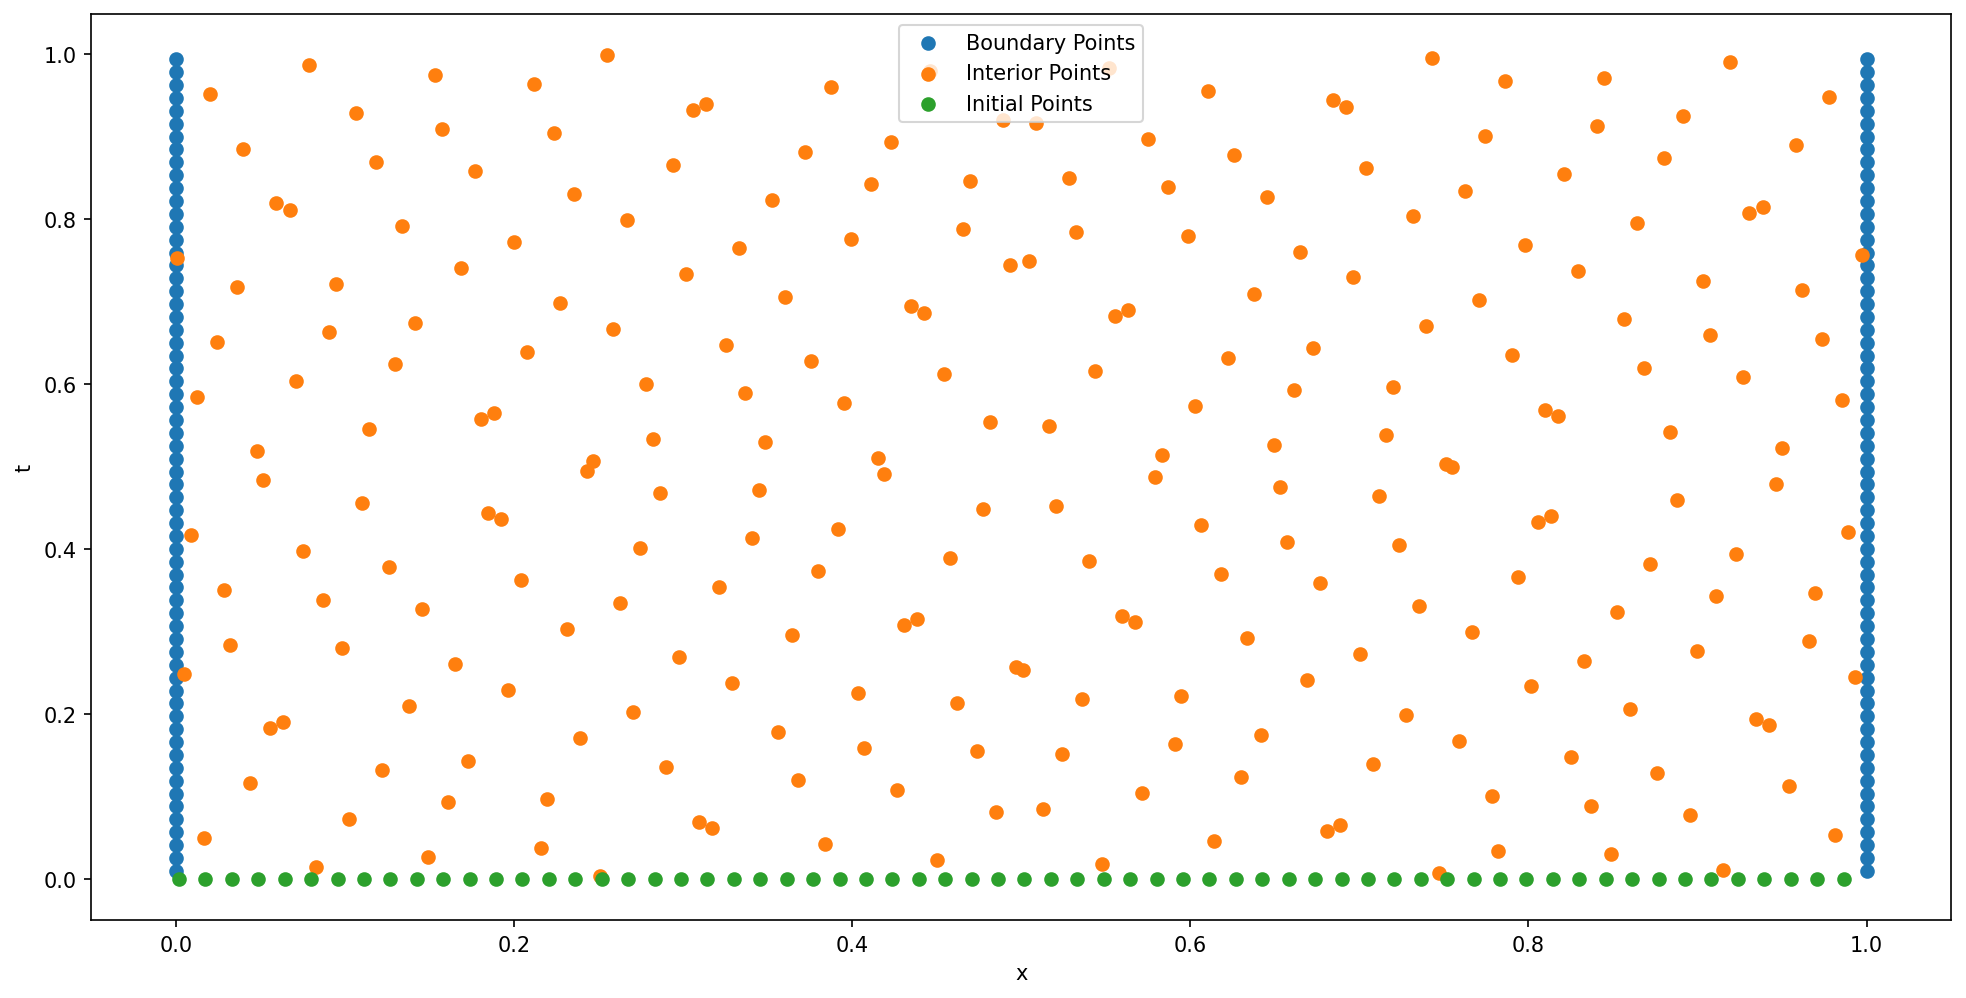

In [5]:
# Plot the input training points
input_sb_, output_sb_ = pinn.add_spatial_boundary_points()
input_tb_, output_tb_ = pinn.add_temporal_boundary_points()
input_int_, output_int_ = pinn.add_interior_points()

plt.figure(figsize=(16, 8), dpi=150)
plt.scatter(input_sb_[:, 1].detach().numpy(), input_sb_[:, 0].detach().numpy(), label="Boundary Points")
plt.scatter(input_int_[:, 1].detach().numpy(), input_int_[:, 0].detach().numpy(), label="Interior Points")
plt.scatter(input_tb_[:, 1].detach().numpy(), input_tb_[:, 0].detach().numpy(), label="Initial Points")
plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.show()

In [6]:
n_epochs = 1
optimizer_LBFGS = optim.LBFGS(pinn.approximate_solution.parameters(),
                              lr=float(0.5),
                              max_iter=50000,
                              max_eval=50000,
                              history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_change=1.0 * np.finfo(float).eps)
optimizer_ADAM = optim.Adam(pinn.approximate_solution.parameters(),
                            lr=float(0.001))

################################  0  ################################
Total loss:  2.0554 | PDE Loss:  0.4104 | Function Loss:  1.9439
Total loss:  2.0142 | PDE Loss:  0.397 | Function Loss:  1.8942
Total loss:  1.7118 | PDE Loss:  0.2894 | Function Loss:  1.5056
Total loss:  1.5574 | PDE Loss:  0.1407 | Function Loss:  1.3476
Total loss:  1.3743 | PDE Loss:  0.0722 | Function Loss:  1.0743
Total loss:  1.2011 | PDE Loss:  0.1345 | Function Loss:  0.3538
Total loss:  1.0637 | PDE Loss:  -0.0492 | Function Loss:  0.4233
Total loss:  1.0064 | PDE Loss:  -0.2403 | Function Loss:  0.6432
Total loss:  0.9279 | PDE Loss:  -0.2859 | Function Loss:  0.5177
Total loss:  0.8765 | PDE Loss:  -0.2971 | Function Loss:  0.3944
Total loss:  0.7568 | PDE Loss:  -0.4004 | Function Loss:  0.2394
Total loss:  0.7421 | PDE Loss:  -0.4402 | Function Loss:  0.2773
Total loss:  0.7118 | PDE Loss:  -0.454 | Function Loss:  0.2133
Total loss:  0.6816 | PDE Loss:  -0.4992 | Function Loss:  0.2137
Total loss:  0

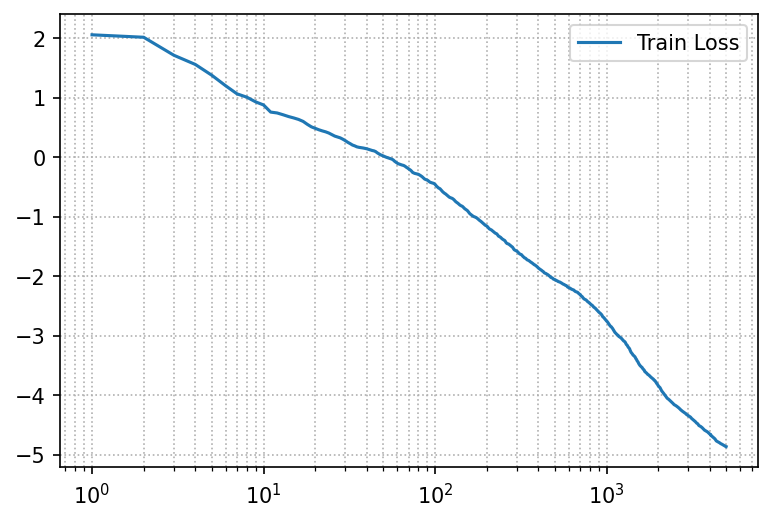

In [7]:
hist = pinn.fit(num_epochs=n_epochs,
                optimizer=optimizer_LBFGS,
                verbose=True)

plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
plt.xscale("log")
plt.legend()

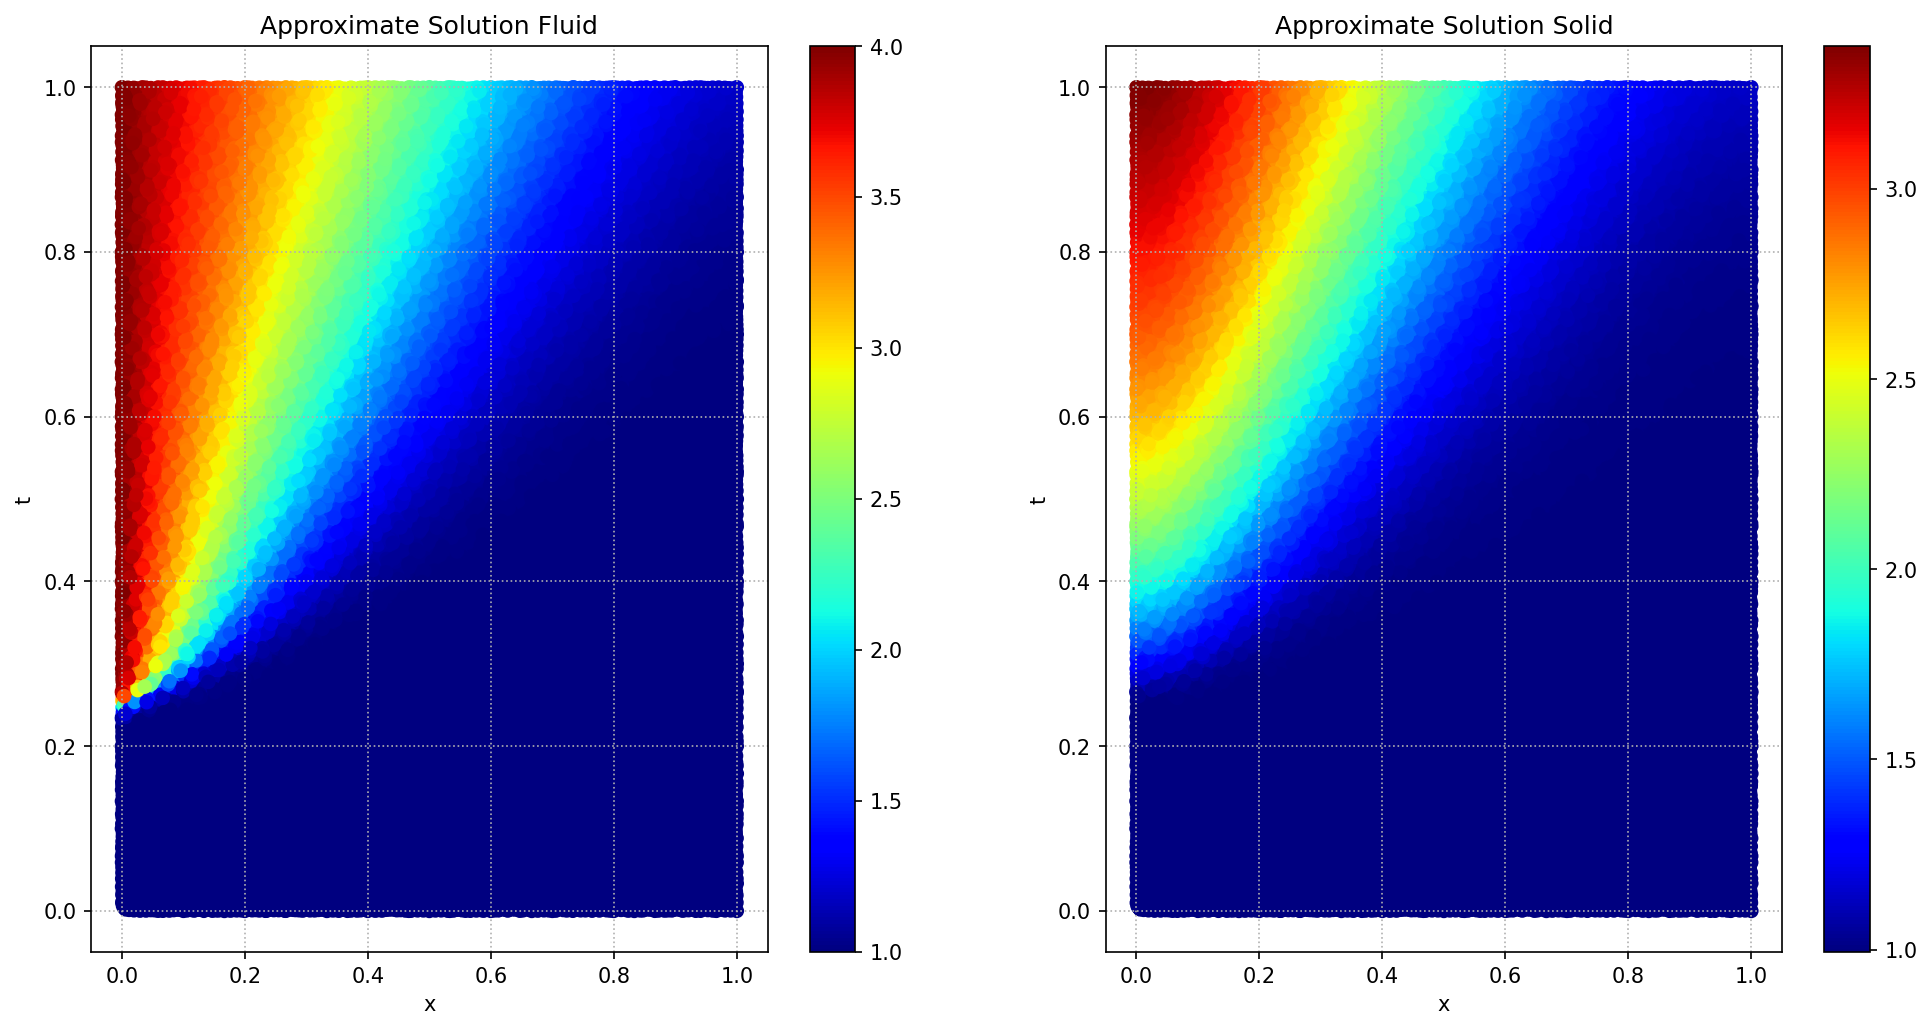

In [8]:
pinn.plotting()

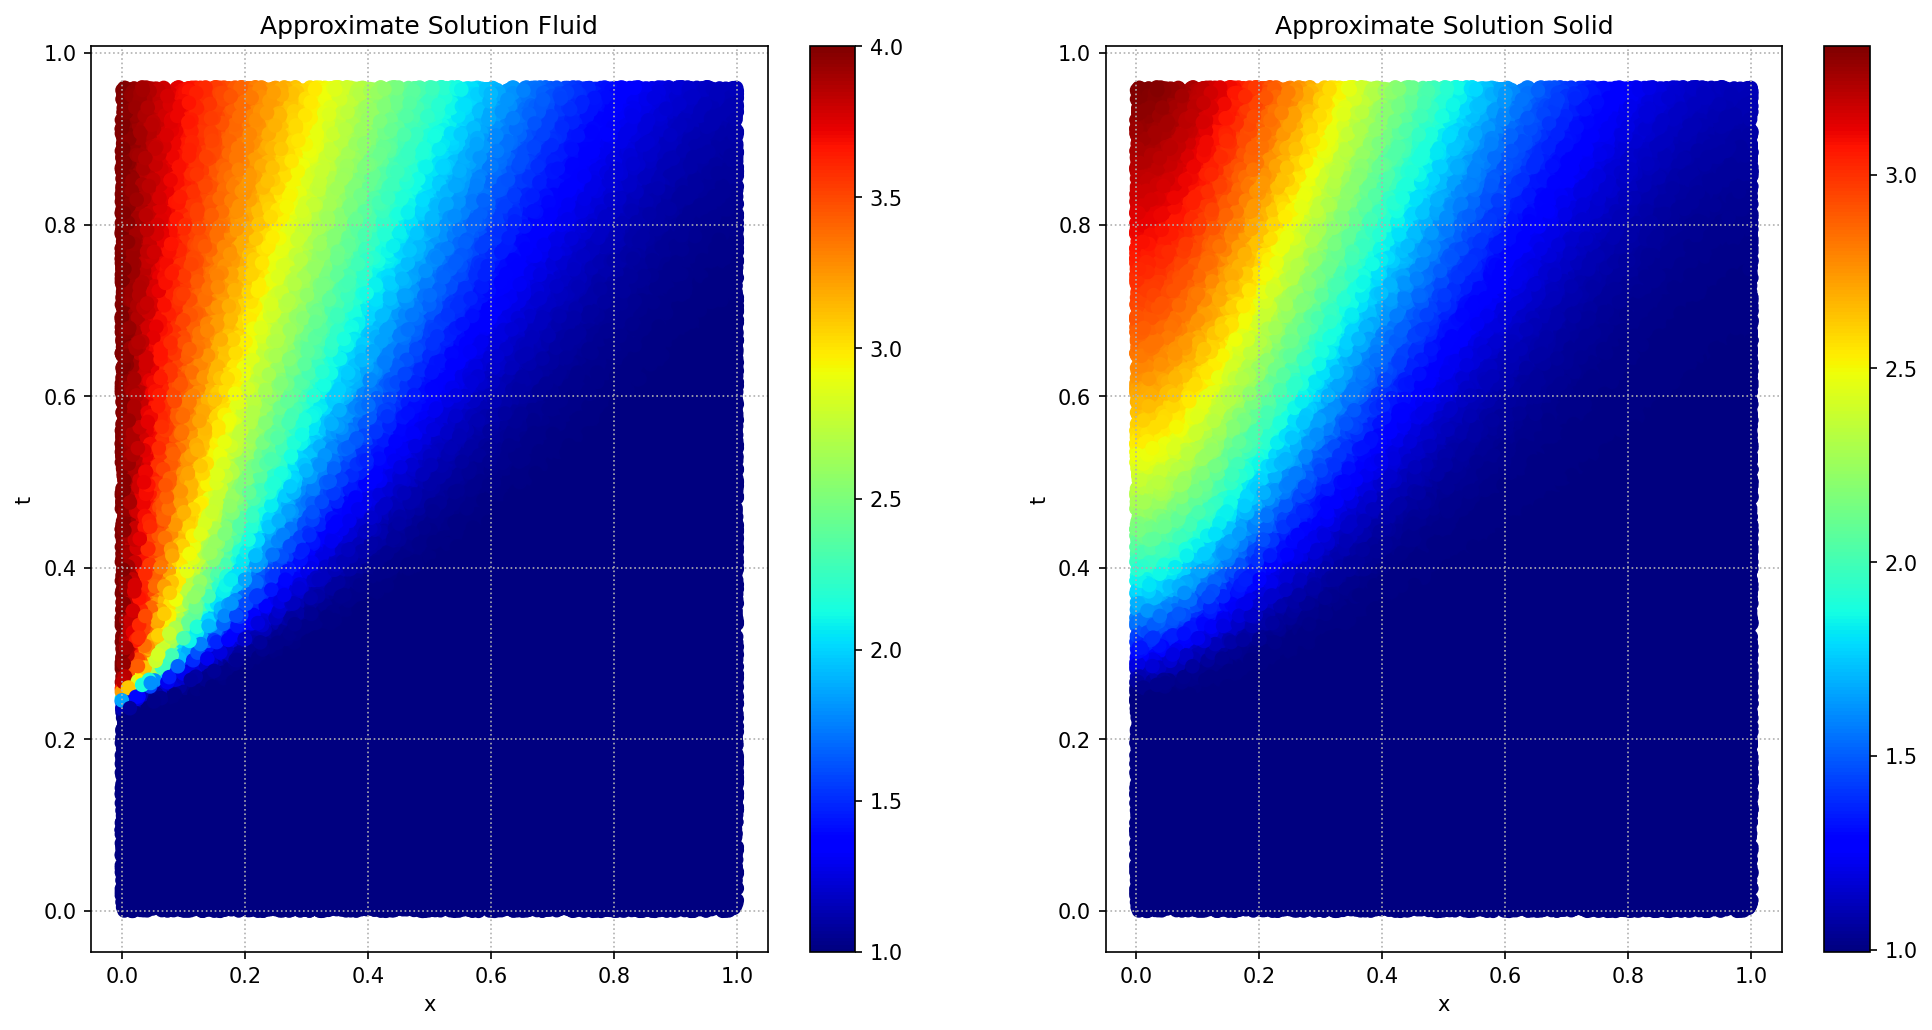

In [17]:
dataset = '/home/anna/AISE/projects/AISE/Project1/Task1/TestingData.txt'
testing_data = torch.tensor(pd.read_csv(dataset, header=0, dtype=np.float32).values,  dtype=torch.float32)

predictions = pinn.approximate_solution(testing_data)

approx_Tf, approx_Ts = predictions[:, 0], predictions[:, 1]

fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
im1 = axs[0].scatter(testing_data[:, 1].detach(), testing_data[:, 0].detach(), c=approx_Tf.detach(), cmap="jet")
axs[0].set_xlabel("x")
axs[0].set_ylabel("t")
plt.colorbar(im1, ax=axs[0])
axs[0].grid(True, which="both", ls=":")
im2 = axs[1].scatter(testing_data[:, 1].detach(), testing_data[:, 0].detach(), c=approx_Ts.detach(), cmap="jet")
axs[1].set_xlabel("x")
axs[1].set_ylabel("t")
plt.colorbar(im2, ax=axs[1])
axs[1].grid(True, which="both", ls=":")
axs[0].set_title("Approximate Solution Fluid")
axs[1].set_title("Approximate Solution Solid")

#plt.show()
plt.savefig('approximate_solution.png')

In [16]:
results = torch.concat((testing_data, predictions), 1)
results = results.detach().numpy()
results = pd.DataFrame(results, columns=['t', 'x', 'tf', 'ts'])
results.to_csv('Task1.txt', index = False)